In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import multivariate_normal
import seaborn as sns
sns.set()
# plt.rcParams['figure.figsize'] = (8.0, 5.0)
%config InlineBackend.figure_format = 'retina'

In [23]:
def cov_to_pts(cov):
    circ = np.linspace(0, 2 * np.pi, 500)
    sf = np.asarray([np.cos(circ), np.sin(circ)])
    [u, s, v] = np.linalg.svd(cov)
    pmat = u * 2.447 * np.sqrt(s) # 95% confidence
    return np.dot(pmat, sf)

def plot(data, means, covs, resp, it):
    color = resp[:,0] / np.sum(resp, axis=1)
    
    # data points & means
    plt.scatter(data[:,0], data[:,1], c=color, cmap='gray', edgecolor='black')
    plt.scatter(means[0,0], means[1,0], s=400, c='white', edgecolor='black')
#     plt.scatter(c2[:,0], c2[:,1], c='black')
    plt.scatter(means[0,1], means[1,1], s=400, c='black')
    
    # elipses
    for i, cov in enumerate(covs):
        pts = cov_to_pts(cov)
        pts += means[:,i:i+1]
        plt.plot(pts[0], pts[1], ls='-', label='Class {}'.format(i + 1))
    
    plt.xticks(np.arange(-3, 4))
    plt.yticks(np.arange(-40, 31, 10))
    plt.xlim([-3, 3])
    plt.ylim([-40, 30])
    plt.title('Iteration #{}'.format(it))
    plt.legend(loc='lower right')
    plt.show()

In [11]:
def init():
    # the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
    mus = np.asarray( [[-1.17288986, -0.11642103],
                       [-0.16526981,  0.70142713]])

    # the Gaussian covariance matrices
    covs = [
        np.asarray([[ 0.74072815,  0.09252716],
                    [ 0.09252716,  0.5966275 ]]),
        np.asarray([[ 0.39312776, -0.46488887],
                    [-0.46488887,  1.64990767]])
    ]

    # The Gaussian mixing weights
    mws = np.array([0.68618439, 0.31381561])  # called alpha in the slides
    
    return mus, covs, mws

In [91]:
def get_responsibilities(data, means, covs, mws):
    p1 = multivariate_normal.pdf(data, mean=means[:,0], cov=covs[0])
    p2 = multivariate_normal.pdf(data, mean=means[:,1], cov=covs[1])
    w1 = (p1 * mws[0]) / (p1*mws[0] + p2*mws[1])
    w2 = (p2 * mws[1]) / (p1*mws[0] + p2*mws[1])
    return np.array([w1, w2]).T

def get_mixing_weights(resp):
    return np.sum(resp, axis=1) / np.sum(resp)

def get_covariances(data, resp, means):
    covs = []
    for i in range(resp.shape[-1]):
        diff = data - means[:,i].T
        summed = diff.T.dot(diff * resp[:,i:i+1])
        covs.append(summed / np.sum(resp[:,i]))
    return covs

def get_means(data, resp):
    means = []
    for i in range(resp.shape[-1]):
        means.append(resp[:,i].T.dot(data) / np.sum(resp[:,i]))
    return np.array(means).T

def train(data, num_iterations, plot_every=1):
    means, covs, mws = init()
    prev = None
    for i in range(num_iterations):
        resp = get_responsibilities(data, means, covs, mws)
        mws = get_mixing_weights(resp)
        prev = covs
        covs = get_covariances(data, resp, means)
        means = get_means(data, resp)
        if i % plot_every == 0:
            plot(data, means, covs, resp, i + 1)

In [87]:
data = loadmat('old_faithful')['data']
data -= np.mean(data, axis=0)

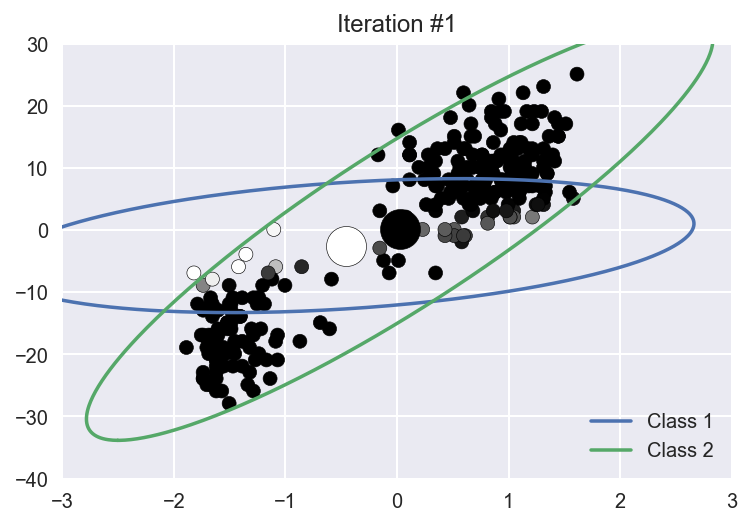

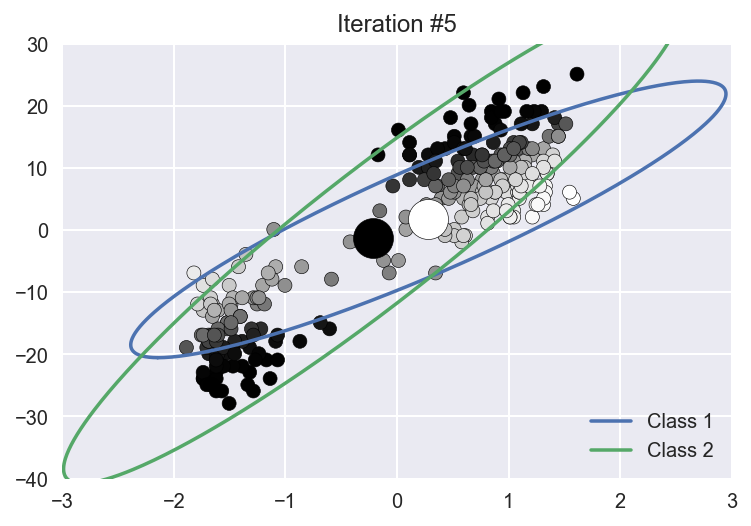

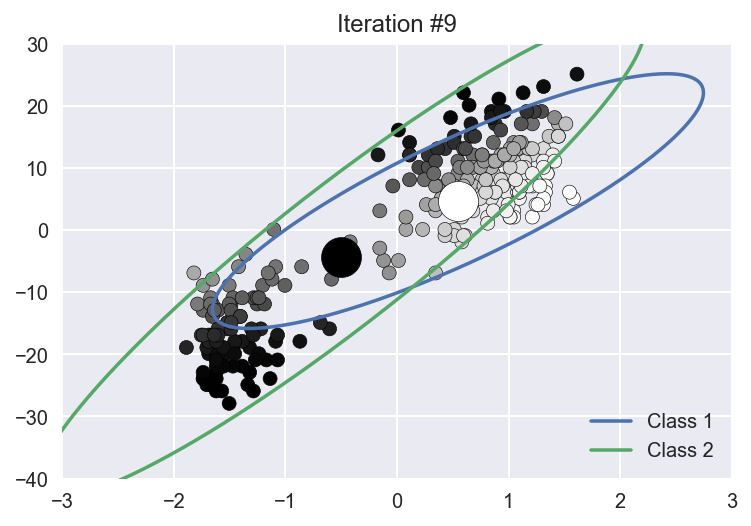

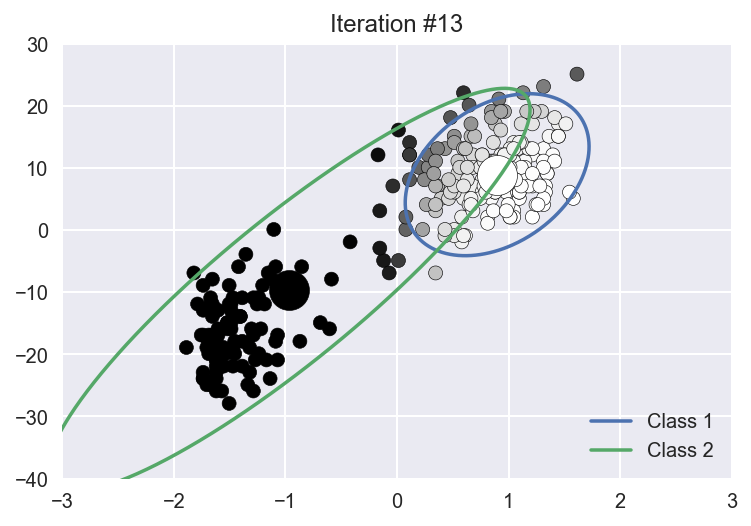

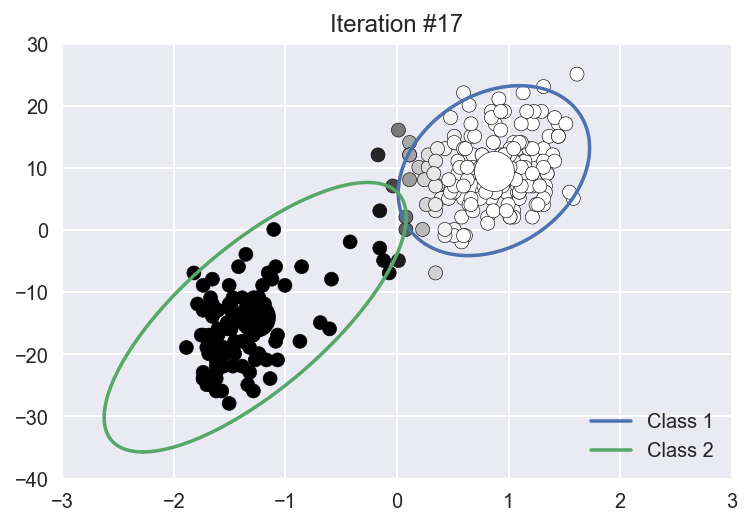

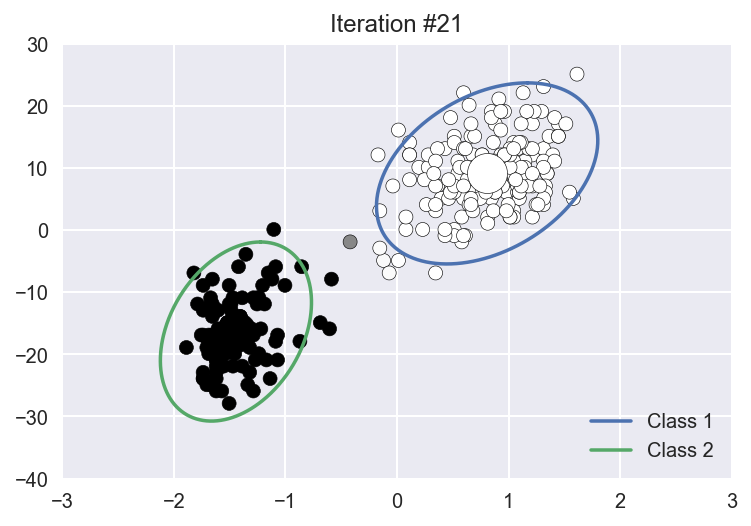

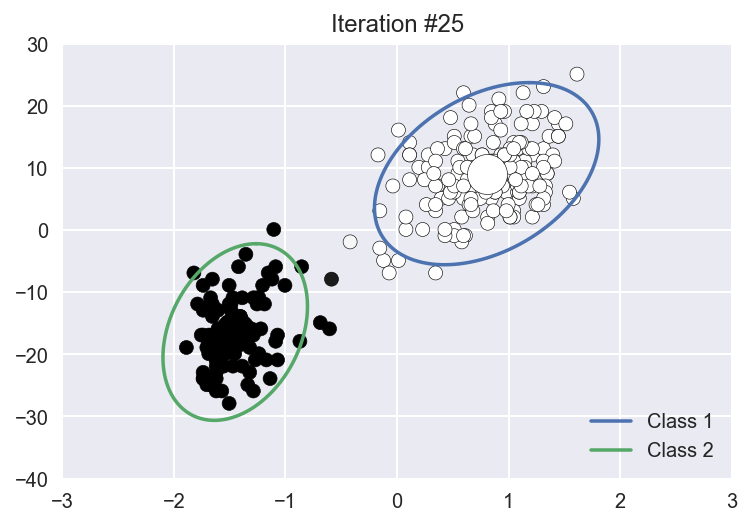

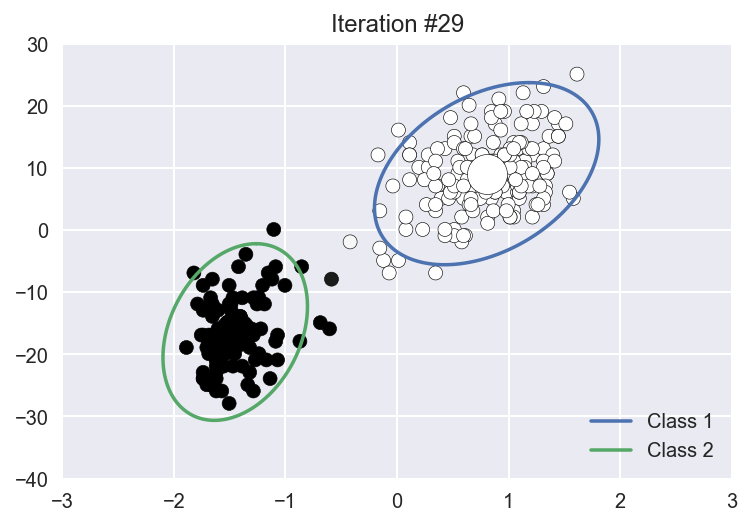

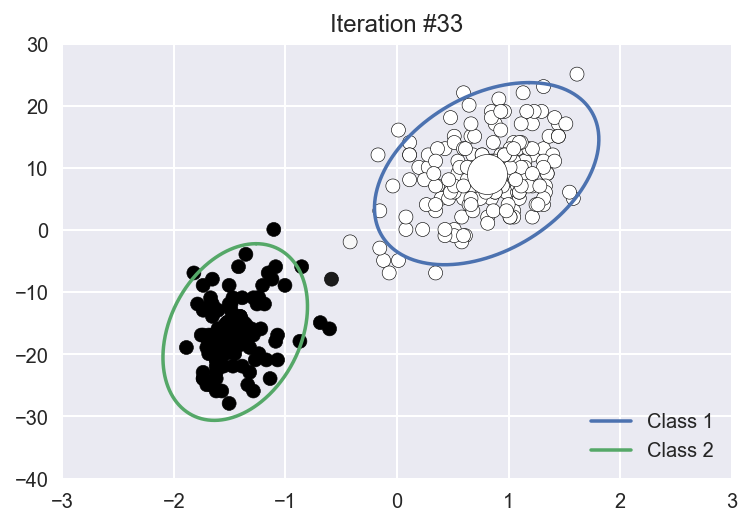

In [93]:
train(data, 33, plot_every=4)